In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pandas as pd
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-01'),
    first_days=5,
    scale=False
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [43]:
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train[idx]
    mean_precip.append(y.max())

In [44]:
mean_precip = np.array(mean_precip)

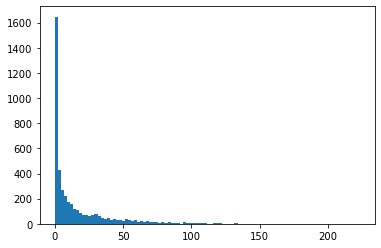

In [47]:
plt.hist(mean_precip, bins=100);
# plt.yscale('log')

In [12]:
cat_bins = np.arange(0, 102, 2, dtype='float')
cat_bins = np.append(np.insert(cat_bins, 1, 0.01), np.inf)
len(cat_bins)

53

In [13]:
cat_bins

array([0.0e+00, 1.0e-02, 2.0e+00, 4.0e+00, 6.0e+00, 8.0e+00, 1.0e+01,
       1.2e+01, 1.4e+01, 1.6e+01, 1.8e+01, 2.0e+01, 2.2e+01, 2.4e+01,
       2.6e+01, 2.8e+01, 3.0e+01, 3.2e+01, 3.4e+01, 3.6e+01, 3.8e+01,
       4.0e+01, 4.2e+01, 4.4e+01, 4.6e+01, 4.8e+01, 5.0e+01, 5.2e+01,
       5.4e+01, 5.6e+01, 5.8e+01, 6.0e+01, 6.2e+01, 6.4e+01, 6.6e+01,
       6.8e+01, 7.0e+01, 7.2e+01, 7.4e+01, 7.6e+01, 7.8e+01, 8.0e+01,
       8.2e+01, 8.4e+01, 8.6e+01, 8.8e+01, 9.0e+01, 9.2e+01, 9.4e+01,
       9.6e+01, 9.8e+01, 1.0e+02,     inf])

In [71]:
X, y = ds_train[600]
X.shape, y.shape

((1, 16, 16), (1, 128, 128))

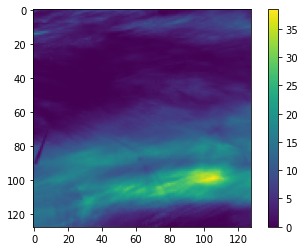

In [72]:
plt.imshow(y[0])
plt.colorbar();

In [6]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """Copied from keras source code
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [88]:
a = pd.cut(y.reshape(-1), cat_bins, labels=False, include_lowest=True).reshape(y.shape)
a.shape

(1, 128, 128)

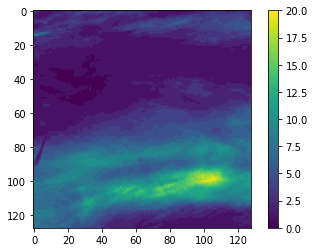

In [89]:
plt.imshow(a[0])
plt.colorbar();

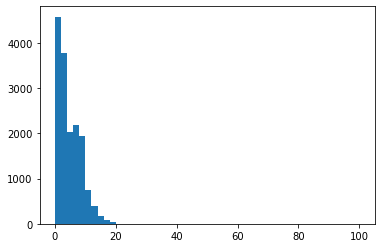

In [93]:
plt.hist(a.flat, bins=cat_bins);

In [94]:
a = to_categorical(a.squeeze(), num_classes=len(cat_bins))

In [95]:
a = np.rollaxis(a, 2)

In [96]:
a.shape

(53, 128, 128)

In [23]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-01'),
    first_days=5,
    scale=True,
    cat_bins=cat_bins
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [42]:
X, y = ds_train[600]
X.shape, y.shape

((1, 16, 16), (128, 128))

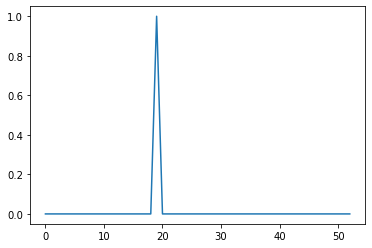

In [25]:
plt.plot(y[:, 100, 100])

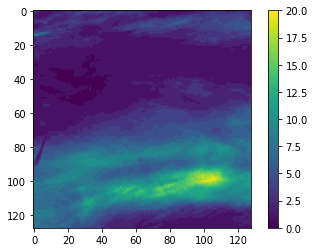

In [26]:
plt.imshow(np.argmax(y, 0))
plt.colorbar()

In [43]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))

In [44]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)

In [45]:
len(dl_train)

134

In [47]:
X, y = next(iter(dl_train))

In [48]:
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 128, 128]))

In [49]:
y.type()

'torch.LongTensor'

In [59]:
class Generator(nn.Module):
    """Generator with noise vector and spectral normalization """
    def __init__(self, nres, nf_in, nf, relu_out=False, use_noise=True, spectral_norm=True,
                 nout=1, softmax_out=False):
        """ General Generator with different options to use. e.g noise, Spectral normalization (SN) """
        super().__init__()
        self.relu_out = relu_out
        self.softmax_out = softmax_out
        self.use_noise = use_noise
        self.spectral_norm = spectral_norm

        # First convolution
        if use_noise: 
            self.conv_in = nn.Conv2d(nf_in, nf-1, kernel_size=9, stride=1, padding=4)
        else: 
            self.conv_in = nn.Conv2d(nf_in, nf, kernel_size=9, stride=1, padding=4)
        self.activation_in = nn.LeakyReLU(0.2)

        # Resblocks keeping shape
        self.resblocks = nn.Sequential(*[
            ResidualBlock(nf, spectral_norm=spectral_norm) for i in range(nres)
        ])
        # Resblocks with upscaling
        self.upblocks = nn.Sequential(*[
            UpsampleBlock(nf, spectral_norm=spectral_norm) for i in range(3)
        ])
        self.conv_out = nn.Conv2d(nf, nout, kernel_size=9, stride=1, padding=4)
        
        if spectral_norm: 
            self.conv_in = nn.utils.spectral_norm(self.conv_in)
            self.conv_out = nn.utils.spectral_norm(self.conv_out)
        
    def forward(self, x):
        out = self.conv_in(x)
        out = self.activation_in(out)
        if self.use_noise: 
            bs, _, h, w = x.shape
            z = torch.normal(0, 1, size=(bs, 1, h, w), device=device, requires_grad=True)
            out = torch.cat([out, z], dim=1)
        skip = out
        out = self.resblocks(out)
        out = out + skip
        out = self.upblocks(out)
        out = self.conv_out(out)
        if self.relu_out:
            out = nn.functional.relu(out)
        if self.softmax_out:
            out = nn.functional.softmax(out, dim=1)
        return out

In [176]:
gen = Generator(
    nres=3, nf_in=1, nf=64, relu_out=False, use_noise=False, spectral_norm=False,
    nout=len(cat_bins), softmax_out=False
).to(device)

In [177]:
count_parameters(gen)

944757

In [178]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-5)

In [179]:
trainer = Trainer(gen, optimizer, criterion, dl_train)

In [180]:
trainer.fit(10)

In [194]:
trainer.fit(10)

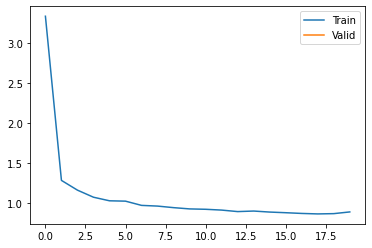

In [195]:
trainer.plot_losses()

In [196]:
preds = nn.functional.softmax(gen(X.to(device)), dim=1).cpu().detach().numpy()

In [197]:
preds.shape

(32, 53, 128, 128)

In [198]:
target = y.cpu().detach().numpy()

In [199]:
target.shape

(32, 128, 128)

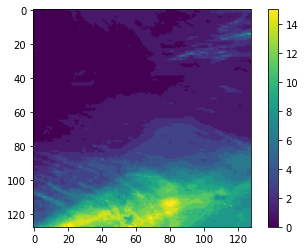

In [200]:
i=4
plt.imshow(target[i])
plt.colorbar()

In [201]:
target[i, 120, 60]

13

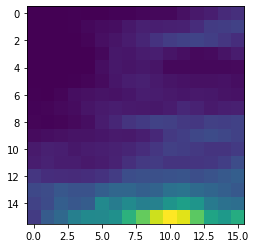

In [202]:
plt.imshow(X[i, 0])

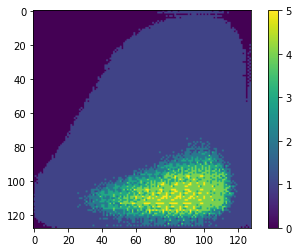

In [203]:
plt.imshow(np.argmax(preds[i], axis=0))
plt.colorbar()

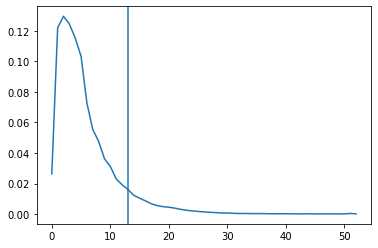

In [204]:
plt.plot(preds[i, :, 120, 60])
plt.axvline(target[i, 120, 60])